# 项目背景
亚马逊作为全球领先的电子商务平台，其畅销书单不仅是读者选择书籍的重要参考，也是出版业趋势的一个风向标。本项目旨在从作者角度，搭建作者标签系统及K-Means聚类，分析畅销书作者的书籍分类、多样性、评分、评论等特征。

技术：可视化plotly；模型Kmeans聚类、标签系统

# 数据说明
数据字段如下：
|字段|含义|
|---|---|
|Name|书名|
|Author|作者|
|User Rating|读者评分|
|Reviews|读者评论数|
|Price|价格|
|Year|年份|
|Genre|是否为小说|


数据来源：https://www.kaggle.com/datasets/sootersaalu/amazon-top-50-bestselling-books-2009-2019/data
# 数据导入

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
colors = ['#ff80a0', '#4456c7', '#b5a6b7']

import seaborn as sns
colors_sns = sns.color_palette('husl')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# 数据导入
data = pd.read_csv('input\\bestsellers with categories.csv', encoding='utf-8')
data

Name  \
0                        10-Day Green Smoothie Cleanse   
1                                    11/22/63: A Novel   
2              12 Rules for Life: An Antidote to Chaos   
3                               1984 (Signet Classics)   
4    5,000 Awesome Facts (About Everything!) (Natio...   
..                                                 ...   
545       Wrecking Ball (Diary of a Wimpy Kid Book 14)   
546  You Are a Badass: How to Stop Doubting Your Gr...   
547  You Are a Badass: How to Stop Doubting Your Gr...   
548  You Are a Badass: How to Stop Doubting Your Gr...   
549  You Are a Badass: How to Stop Doubting Your Gr...   

                       Author  User Rating  Reviews  Price  Year        Genre  
0                    JJ Smith          4.7    17350      8  2016  Non Fiction  
1                Stephen King          4.6     2052     22  2011      Fiction  
2          Jordan B. Peterson          4.7    18979     15  2018  Non Fiction  
3               George Orwell          4.7    21424      6  2017      Fiction  
4    National Geographic Kids          4.8     7665     12  2019  Non Fiction  
..                        ...          ...      ...    ...   ...          ...  
545               Jeff Kinney          4.9     9413      8  2019      Fiction  
546               Jen Sincero          4.7    14331      8  2016  Non Fiction  
547               Jen Sincero          4.7    14331      8  2017  Non Fiction  
548               Jen Sincero          4.7    14331      8  2018  Non Fiction  
549               Jen Sincero          4.7    14331      8  2019  Non Fiction  

[550 rows x 7 columns]

# 数据预处理

## 数据基本信息

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         550 non-null    object 
 1   Author       550 non-null    object 
 2   User Rating  550 non-null    float64
 3   Reviews      550 non-null    int64  
 4   Price        550 non-null    int64  
 5   Year         550 non-null    int64  
 6   Genre        550 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 30.2+ KB


## 数据异常值情况

In [4]:
data.describe()

User Rating       Reviews       Price         Year
count   550.000000    550.000000  550.000000   550.000000
mean      4.618364  11953.281818   13.100000  2014.000000
std       0.226980  11731.132017   10.842262     3.165156
min       3.300000     37.000000    0.000000  2009.000000
25%       4.500000   4058.000000    7.000000  2011.000000
50%       4.700000   8580.000000   11.000000  2014.000000
75%       4.800000  17253.250000   16.000000  2017.000000
max       4.900000  87841.000000  105.000000  2019.000000

数据集基本没有异常值。

# 数据重复值情况

In [5]:
print('重复记录条数为：' + str(data.duplicated().sum()))

重复记录条数为：0


## 列处理

In [6]:
# 提取书籍是否为某个系列的其中一个作品
def get_series(value):
    string = value.split(':')
    if len(string) > 1:
        return string[0]
    else:
        return ''

In [7]:
data['SeriesType'] = ''
data['Series'] = ''
data['Series'] = data['Name'].apply(get_series)
data['SeriesType'] = data['Series'].apply(lambda x: 'no' if x=='' else 'yes')

In [8]:
# 最终数据源如下
data.head(5)

Name  \
0                      10-Day Green Smoothie Cleanse   
1                                  11/22/63: A Novel   
2            12 Rules for Life: An Antidote to Chaos   
3                             1984 (Signet Classics)   
4  5,000 Awesome Facts (About Everything!) (Natio...   

                     Author  User Rating  Reviews  Price  Year        Genre  \
0                  JJ Smith          4.7    17350      8  2016  Non Fiction   
1              Stephen King          4.6     2052     22  2011      Fiction   
2        Jordan B. Peterson          4.7    18979     15  2018  Non Fiction   
3             George Orwell          4.7    21424      6  2017      Fiction   
4  National Geographic Kids          4.8     7665     12  2019  Non Fiction   

  SeriesType             Series  
0         no                     
1        yes           11/22/63  
2        yes  12 Rules for Life  
3         no                     
4         no

# 数据分析

## 作品上榜情况

In [9]:
data_book = data[['Name']].drop_duplicates()
data_author = data[['Author']].drop_duplicates()

data_book_g = data.groupby(by='Name', as_index=False)['Author'].count()
print('本数据集为' + str(data['Year'].min()) + '-' + str(data['Year'].max()) + '年数据：\n' +
      '榜单共' + str(len(data)) + '次，共有' + str(len(data_book)) + '本书上榜，涉及作者共' + str(len(data_author)) + '位\n' + 
      '评分范围为:' + str(data['User Rating'].min()) + '-' + str(data['User Rating'].max()) + 
      '\n涉及评论数为：' + str(data['Reviews'].sum()))
# data_book_g

本数据集为2009-2019年数据：
榜单共550次，共有351本书上榜，涉及作者共248位
评分范围为:3.3-4.9
涉及评论数为：6574305


## 各年上榜趋势

In [10]:
data_book_y = data.groupby(by=['Year'], as_index=False).agg({'User Rating': 'mean','Reviews':'sum'})
data_book_y

Year  User Rating  Reviews
0   2009        4.584   235506
1   2010        4.558   273981
2   2011        4.558   405041
3   2012        4.532   654546
4   2013        4.554   654907
5   2014        4.622   792997
6   2015        4.648   711669
7   2016        4.678   709800
8   2017        4.660   644420
9   2018        4.668   696521
10  2019        4.740   794917

In [11]:
# 可视化
fig = make_subplots(rows=1,cols=2)
fig.add_trace(go.Scatter(
    x=data_book_y['Year'], y=data_book_y['User Rating'], name='Average User Rating'
), row=1,col=1)
fig.add_trace(go.Bar(
    x=data_book_y['Year'], y=data_book_y['Reviews'], name='Total User Review'
),row=1,col=2)
fig.show()

可以看出，2012年书籍评分出现一个低估（低于4.5分）以下，历年畅销书平均评分基本为上升趋势。2014年读者评论数出现一个峰值，最新的连续3年（2017-2019年）评论数也呈上升趋势。

## 作品类型占比

In [12]:
data_cat = data[['Name', 'Genre']].drop_duplicates()
data_cat = data_cat.groupby(by=['Genre'], as_index=False).agg({'Name': 'count'})
data_cat_ra = data.groupby(by=['Genre', 'Year'], as_index=False).agg({'User Rating': 'mean', 'Name': 'count', 'Reviews':'sum'})
data_cat

Genre  Name
0      Fiction   160
1  Non Fiction   191

In [13]:
# 可视化
fig = make_subplots(rows=2,cols=2, specs=[[{'type':'pie'},{'type':'bar'}], [{'type':'bar'}, {'type': 'scatter'}]])
fig.add_trace(go.Pie(
    labels=data_cat['Genre'],
    values=data_cat['Name'],
    marker=dict(colors=colors),
    pull=[0.05,0]
),row=1,col=1)

fig.add_trace(go.Bar(
    x=data_cat_ra[data_cat_ra['Genre'] == 'Fiction']['Year'], y=data_cat_ra[data_cat_ra['Genre'] == 'Fiction']['Name'], name='Fiction Books'
),row=1,col=2)
fig.add_trace(go.Bar(
    x=data_cat_ra[data_cat_ra['Genre'] == 'Non Fiction']['Year'], y=data_cat_ra[data_cat_ra['Genre'] == 'Non Fiction']['Name'], name='Non Fiction Books'
),row=1,col=2)

fig.add_trace(go.Scatter(
    x=data_cat_ra[data_cat_ra['Genre'] == 'Fiction']['Year'], y=data_cat_ra[data_cat_ra['Genre'] == 'Fiction']['User Rating'], name='Fiction Rating'
),row=2,col=2)
fig.add_trace(go.Scatter(
    x=data_cat_ra[data_cat_ra['Genre'] == 'Non Fiction']['Year'], y=data_cat_ra[data_cat_ra['Genre'] == 'Non Fiction']['User Rating'],  name='Non Fiction Rating'
),row=2,col=2)

fig.add_trace(go.Bar(
    x=data_cat_ra[data_cat_ra['Genre'] == 'Fiction']['Year'], y=data_cat_ra[data_cat_ra['Genre'] == 'Fiction']['Reviews'], name='Fiction Reviews'
),row=2,col=1)
fig.add_trace(go.Bar(
    x=data_cat_ra[data_cat_ra['Genre'] == 'Non Fiction']['Year'], y=data_cat_ra[data_cat_ra['Genre'] == 'Non Fiction']['Reviews'],  name='Non Fiction Reviews'
),row=2,col=1)

fig.show()

可以看出：
- 全量榜单中非小说数量略多于小说数量
- 畅销书中小说的数量在2014年出现一个峰值。非小说书籍从2015年开始数量超过小说书籍
- 小说书籍的读者评论数从2009年开始到2014年出现明显上升趋势，之后逐渐减少，并在2018年开始少于非小说书籍
- 小说书籍除了2012年低于非小说书籍外，普遍高于非小说书籍，且随着年份评分持续上涨。非小说书籍评分历年基本持平

## 是否系列占比

In [14]:
data_cat = data[['Name', 'SeriesType']].drop_duplicates()
data_cat = data_cat.groupby(by=['SeriesType'], as_index=False)['Name'].count()
data_cat_ra = data.groupby(by=['SeriesType', 'Year'], as_index=False).agg({'User Rating': 'mean', 'Name': 'count', 'Reviews':'sum'})
data_cat

SeriesType  Name
0         no   167
1        yes   184

In [15]:
# 可视化
fig = make_subplots(rows=2,cols=2, specs=[[{'type':'pie'},{'type':'bar'}], [{'type':'bar'}, {'type': 'scatter'}]])
fig.add_trace(go.Pie(
    labels=data_cat['SeriesType'],
    values=data_cat['Name'],
    marker=dict(colors=colors),
    pull=[0.05,0]
),row=1,col=1)

fig.add_trace(go.Bar(
    x=data_cat_ra[data_cat_ra['SeriesType'] == 'yes']['Year'], y=data_cat_ra[data_cat_ra['SeriesType'] == 'yes']['Name'], name='Series Books'
),row=1,col=2)
fig.add_trace(go.Bar(
    x=data_cat_ra[data_cat_ra['SeriesType'] == 'no']['Year'], y=data_cat_ra[data_cat_ra['SeriesType'] == 'no']['Name'], name='Non Series Books'
),row=1,col=2)

fig.add_trace(go.Scatter(
    x=data_cat_ra[data_cat_ra['SeriesType'] == 'yes']['Year'], y=data_cat_ra[data_cat_ra['SeriesType'] == 'yes']['User Rating'], name='Series Rating'
),row=2,col=2)
fig.add_trace(go.Scatter(
    x=data_cat_ra[data_cat_ra['SeriesType'] == 'no']['Year'], y=data_cat_ra[data_cat_ra['SeriesType'] == 'no']['User Rating'],  name='Non Series Rating'
),row=2,col=2)

fig.add_trace(go.Bar(
    x=data_cat_ra[data_cat_ra['SeriesType'] == 'yes']['Year'], y=data_cat_ra[data_cat_ra['SeriesType'] == 'yes']['Reviews'], name='Series Reviews'
),row=2,col=1)
fig.add_trace(go.Bar(
    x=data_cat_ra[data_cat_ra['SeriesType'] == 'no']['Year'], y=data_cat_ra[data_cat_ra['SeriesType'] == 'no']['Reviews'],  name='Non Series Reviews'
),row=2,col=1)

fig.show()

可以看出：
- 全量数据中系列书籍与非系列书籍数量较为接近
- 系列书籍在2014年数量较少，明显少于非系列书籍，其它年份二者数量接近且波动不大
- 非系列书籍评论数在2014年出现峰值，且明显高于同年的系列书籍。其它年份二者接近，随着年份呈上升趋势
- 系列书籍与非系列书籍评分接近，且都随年份呈上升趋势

# 作者侧数据分析

## 作者上榜书本量

In [16]:
author_file = data[['Author']].drop_duplicates()
author_file = author_file.reset_index(drop=True)

In [17]:
author_and_book = data[['Author', 'Name']].drop_duplicates()
author_b_c = author_and_book.groupby(by='Author', as_index=False).agg({'Name': 'count'})
author_b_c.columns = ['Author', 'BooksCount']
author_file = pd.merge(author_file, author_b_c, how='left', on='Author')
author_file

Author  BooksCount
0                    JJ Smith           1
1                Stephen King           4
2          Jordan B. Peterson           1
3               George Orwell           1
4    National Geographic Kids           1
..                        ...         ...
243            Cheryl Strayed           1
244               Ken Follett           1
245               Geneen Roth           1
246             R. J. Palacio           1
247               Jen Sincero           1

[248 rows x 2 columns]

In [18]:
# 可视化
data_fig1 = author_file.groupby(by='BooksCount', as_index=False).agg({'Author': 'count'})
data_fig2 = author_file.sort_values(by='BooksCount', ascending=False).head(10)
fig = make_subplots(rows=1, cols=2)
fig.add_bar(x=data_fig1['BooksCount'], y=data_fig1['Author'], row=1, col=1, name='上榜书本量作者分布')
fig.add_bar(y=data_fig2['Author'], x=data_fig2['BooksCount'], orientation='h', row=1, col=2, name='上榜书本量TOP10作者')
fig.show()

可以看出普遍的畅销书作者上榜书本为1本，即类似于“成名作”形式。少量作者有多本上过榜单的书籍。上榜书本最多的为 Jeff Kinney 和 Rick Riordan，上榜书本量达到12次和10次。

注：Jeff Kinney 主要作品为《小屁孩日记》系列；Rick Riordan 主要作品为奇幻小说《波西·杰克逊》。

## 作者上榜频率

In [19]:
author_b_c = data.groupby(by='Author', as_index=False).agg({'Year': 'count'})
author_b_c.columns = ['Author', 'AppearanceCount']
author_file = pd.merge(author_file, author_b_c, how='left', on='Author')
author_file

Author  BooksCount  AppearanceCount
0                    JJ Smith           1                1
1                Stephen King           4                4
2          Jordan B. Peterson           1                1
3               George Orwell           1                1
4    National Geographic Kids           1                1
..                        ...         ...              ...
243            Cheryl Strayed           1                1
244               Ken Follett           1                1
245               Geneen Roth           1                1
246             R. J. Palacio           1                5
247               Jen Sincero           1                4

[248 rows x 3 columns]

In [20]:
# 可视化
data_fig1 = author_file.groupby(by='AppearanceCount', as_index=False).agg({'Author': 'count'})
data_fig2 = author_file.sort_values(by='AppearanceCount', ascending=False).head(10)
fig = make_subplots(rows=1, cols=2)
fig.add_bar(x=data_fig1['AppearanceCount'], y=data_fig1['Author'], row=1, col=1, name='上榜频率作者分布')
fig.add_bar(y=data_fig2['Author'], x=data_fig2['AppearanceCount'], orientation='h', row=1, col=2, name='上榜频率TOP10作者')
fig.show()

可以看出，作者的上榜次数主要为1次，即很少常驻榜单的作者。上榜次数最多的为 Jeff Kinney、Gary Chapman、Rick Riordan、Suzanne Collins，上榜次数都超过10次。

注：Gary Chapman 是一位著名的婚姻辅导专家，主要作品有《爱的五种语言》系列；Suzanne Collins 的主要作品有《饥饿游戏》、《地下城》系列等。

## 作品类型和多样性

In [21]:
# 作者的畅销书作品类别数量
author_and_genre = data[['Author', 'Genre']].drop_duplicates()
author_g_g = author_and_genre.groupby(by=['Author'], as_index=False).agg({'Genre':'count'})
author_g_g.columns = ['Author', 'GenreType']
author_file = pd.merge(author_file, author_g_g, how='left', on='Author')
author_file

Author  BooksCount  AppearanceCount  GenreType
0                    JJ Smith           1                1          1
1                Stephen King           4                4          1
2          Jordan B. Peterson           1                1          1
3               George Orwell           1                1          1
4    National Geographic Kids           1                1          1
..                        ...         ...              ...        ...
243            Cheryl Strayed           1                1          1
244               Ken Follett           1                1          1
245               Geneen Roth           1                1          1
246             R. J. Palacio           1                5          1
247               Jen Sincero           1                4          1

[248 rows x 4 columns]

In [22]:
# 可视化
data_fig1 = author_file.groupby(by='GenreType', as_index=False).agg({'Author': 'count'})
fig = make_subplots(rows=1, cols=2)
trace0 = go.Pie(
    labels=data_fig1['GenreType'],
    values=data_fig1['Author'],
    hole=0.7
)

fig = go.Figure(data=[trace0])
fig.show()

In [23]:
# 作者的书籍类型主攻方向（小说/非小说）
author_genre_book = data[['Author', 'Genre', 'Name']].drop_duplicates()
author_gen_g = author_genre_book.groupby(by=['Author', 'Genre'], as_index=False)['Name'].count()
author_gen_g = author_gen_g.sort_values(by=['Name'], ascending=False)
author_gen_g = author_gen_g.groupby(by=['Author'], as_index=False).head(1)[['Author', 'Genre']]
author_gen_g.columns = ['Author', 'GenreLike']
author_file = pd.merge(author_file, author_gen_g, how='left', on='Author')
author_file

Author  BooksCount  AppearanceCount  GenreType  \
0                    JJ Smith           1                1          1   
1                Stephen King           4                4          1   
2          Jordan B. Peterson           1                1          1   
3               George Orwell           1                1          1   
4    National Geographic Kids           1                1          1   
..                        ...         ...              ...        ...   
243            Cheryl Strayed           1                1          1   
244               Ken Follett           1                1          1   
245               Geneen Roth           1                1          1   
246             R. J. Palacio           1                5          1   
247               Jen Sincero           1                4          1   

       GenreLike  
0    Non Fiction  
1        Fiction  
2    Non Fiction  
3        Fiction  
4    Non Fiction  
..           ...  
243  Non Fiction  
244      Fiction  
245  Non Fiction  
246      Fiction  
247  Non Fiction  

[248 rows x 5 columns]

In [24]:
# 可视化
data_fig1 = author_file.groupby(by='GenreLike', as_index=False).agg({'Author': 'count'})
trace0 = go.Pie(
    labels=data_fig1['GenreLike'], 
    values=data_fig1['Author'],
    hole=0.7
)
fig = go.Figure(data=[trace0])
fig.show()

可以看出，畅销书作者基本都专攻一种分类的书籍。其中更偏好写非小说类的作者占比更多。

## 作者知名度
作者知名度由四个指标组成，分别是 （单本书籍）最大评论数、（单本书籍）最高评分数、（所有书籍）总评论数、（所有书籍）平均评分数。

In [25]:
author_comment_g1 = data.groupby(by=['Author'], as_index=False).agg({'Reviews': 'max', 'User Rating':'mean'})
author_comment_g2 = data.groupby(by=['Author'], as_index=False).agg({'Reviews': 'sum', 'User Rating': 'max'})
author_comment_g1.columns = ['Author', 'MaxReviews', 'MeanRating']
author_comment_g2.columns = ['Author', 'SumReviews', 'MaxRating']
author_file = pd.merge(author_file, author_comment_g1, how='left', on='Author')
author_file = pd.merge(author_file, author_comment_g2, how='left', on='Author')
author_file['MaxRating_Tag'] = pd.cut(author_file['MaxRating'], bins=[0,4,4.2,4.5,4.7, 4.9,5], labels=['<4', '4~4.2', '4.2~4.5', '4.5~4.7', '4.8~4.9','5'], right=True)
author_file['SumReview_Tag'] = pd.cut(
    author_file['SumReviews'], 
    bins=[0,5000, 10000, 20000, 30000,50000,100000, 200000,300000],
labels=['<5K', '5K~1W', '1W~2W','2W~3W', '3W~5W', '5W~10W', '10W~20W', '20W~30W'],
    right=False)
author_file

Author  BooksCount  AppearanceCount  GenreType  \
0                    JJ Smith           1                1          1   
1                Stephen King           4                4          1   
2          Jordan B. Peterson           1                1          1   
3               George Orwell           1                1          1   
4    National Geographic Kids           1                1          1   
..                        ...         ...              ...        ...   
243            Cheryl Strayed           1                1          1   
244               Ken Follett           1                1          1   
245               Geneen Roth           1                1          1   
246             R. J. Palacio           1                5          1   
247               Jen Sincero           1                4          1   

       GenreLike  MaxReviews  MeanRating  SumReviews  MaxRating MaxRating_Tag  \
0    Non Fiction       17350       4.700       17350        4.7       4.5~4.7   
1        Fiction       15845       4.525       29385        4.7       4.5~4.7   
2    Non Fiction       18979       4.700       18979        4.7       4.5~4.7   
3        Fiction       21424       4.700       21424        4.7       4.5~4.7   
4    Non Fiction        7665       4.800        7665        4.8       4.8~4.9   
..           ...         ...         ...         ...        ...           ...   
243  Non Fiction       17044       4.400       17044        4.4       4.2~4.5   
244      Fiction       10760       4.500       10760        4.5       4.2~4.5   
245  Non Fiction        1302       4.200        1302        4.2         4~4.2   
246      Fiction       21625       4.800      108125        4.8       4.8~4.9   
247  Non Fiction       14331       4.700       57324        4.7       4.5~4.7   

    SumReview_Tag  
0           1W~2W  
1           2W~3W  
2           1W~2W  
3           2W~3W  
4           5K~1W  
..            ...  
243         1W~2W  
244         1W~2W  
245           <5K  
246       10W~20W  
247        5W~10W  

[248 rows x 11 columns]

In [26]:
# 可视化
data_fig1 = author_file.groupby(by='MaxRating_Tag', as_index=False).agg({'Author': 'count'})
data_fig2 = author_file.groupby(by='SumReview_Tag', as_index=False).agg({'Author': 'count'})
fig = make_subplots(rows=1,cols=2,specs=[[{'type':'pie'}, {'type':'bar'}]])
fig.add_trace(go.Pie(
    labels=data_fig1['MaxRating_Tag'], 
    values=data_fig1['Author'],
    hole=0.7
),row=1,col=1)
fig.add_trace(go.Bar(
    x=data_fig2['SumReview_Tag'],
    y=data_fig2['Author'],
    name='总评论数'
),row=1,col=2)
fig.show()

可以看出，各作者最高评分主要集中在4.5~4.7，分数越高越难维持，符合上文的作者主要上榜次数为1的情况。作者的总评论数普遍小于2W，基本为单本书籍的评论数。

# 作者聚类 K-Means
K-Means 算法是一种无监督的据类算法，其核心思想是：对于给定的样本集，按照样本点之间的距离大小，将样本集划分为 K 个簇，让簇内的点尽量紧凑，簇间的点尽量分开。

In [27]:
# 抽取指标模型
features = author_file[['BooksCount', 'AppearanceCount', 'GenreType', 'GenreLike', 'MaxReviews',
    'MeanRating']]

mapping_dict = {
    'GenreLike': {'Fiction': 1, 'Non Fiction': 0},
}
for key, values in mapping_dict.items():
    features[key] = features[key].map(values)

features = features.reset_index(drop=True)
features

BooksCount  AppearanceCount  GenreType  GenreLike  MaxReviews  MeanRating
0             1                1          1          0       17350       4.700
1             4                4          1          1       15845       4.525
2             1                1          1          0       18979       4.700
3             1                1          1          1       21424       4.700
4             1                1          1          0        7665       4.800
..          ...              ...        ...        ...         ...         ...
243           1                1          1          0       17044       4.400
244           1                1          1          1       10760       4.500
245           1                1          1          0        1302       4.200
246           1                5          1          1       21625       4.800
247           1                4          1          0       14331       4.700

[248 rows x 6 columns]

## 聚类簇 K 值选择

Text(0.5, 1.0, '轮廓系数图')

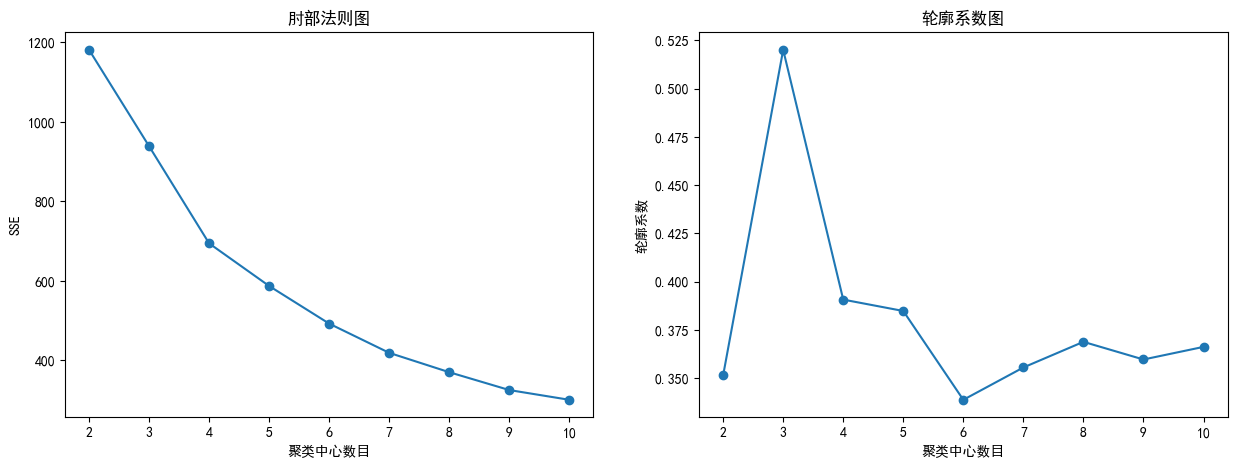

In [28]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

inertia = []
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=15,n_init=10).fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('聚类中心数目')
plt.ylabel('SSE')
plt.title('肘部法则图')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('聚类中心数目')
plt.ylabel('轮廓系数')
plt.title('轮廓系数图')

通过肘部法则图观察到 K=4 到 K=5 之间下降率开始减少。通过轮廓系数可以观察到，轮廓系数在 K=3 时最高，之后随着聚类数的增加而减少。
二者结合后，我们更倾向于 K=4，因为它提供了更合理的聚类数量和聚类质量。

In [29]:
# 使用 K-Means 进行聚类
kmeans = KMeans(n_clusters=4, random_state=15,n_init=10)
kmeans.fit(scaled_features) # 拟合
labels = kmeans.labels_  # 获取聚类结果
features['Cluster'] = kmeans.labels_
author_file['Cluster'] = kmeans.labels_

可视化聚类结果如下：

In [30]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
plt.figure(figsize=(12, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', marker='o')
centers = kmeans.cluster_centers_
reduced_centers = pca.transform(centers)
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='red', s=200, alpha=0.75, marker='x')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('站点聚类结果')

Text(0.5, 1.0, '站点聚类结果')

In [31]:
features.describe()

BooksCount  AppearanceCount   GenreType   GenreLike    MaxReviews  \
count  248.000000       248.000000  248.000000  248.000000    248.000000   
mean     1.415323         2.217742    1.008065    0.362903  11073.713710   
std      1.272922         2.046268    0.089621    0.481810  12081.032882   
min      1.000000         1.000000    1.000000    0.000000    220.000000   
25%      1.000000         1.000000    1.000000    0.000000   3557.000000   
50%      1.000000         1.000000    1.000000    0.000000   7607.500000   
75%      1.000000         2.000000    1.000000    1.000000  13631.250000   
max     12.000000        12.000000    2.000000    1.000000  87841.000000   

       MeanRating     Cluster  
count  248.000000  248.000000  
mean     4.605810    0.758065  
std      0.202303    0.588293  
min      3.900000    0.000000  
25%      4.500000    0.000000  
50%      4.600000    1.000000  
75%      4.800000    1.000000  
max      4.900000    3.000000

各聚类分类的基本情况如下：

In [32]:
BooksCount = []
AppearanceCount = []
GenreType = []
GenreLike = []
MaxReviews = []
MeanRating = []
AuthorCount = []
for i in range(4):
    BooksCount.append(str(round(features[features['Cluster'] == i]['BooksCount'].quantile(0.25),2))+' - '+str(round(features[features['Cluster'] == i]['BooksCount'].quantile(0.75),2)))
    AppearanceCount.append(str(round(features[features['Cluster'] == i]['AppearanceCount'].quantile(0.25),2))+' - '+str(round(features[features['Cluster'] == i]['AppearanceCount'].quantile(0.75),2)))
    GenreType.append(str(round(features[features['Cluster'] == i]['GenreType'].quantile(0.25),2))+' - '+str(round(features[features['Cluster'] == i]['GenreType'].quantile(0.75),2)))
    GenreLike.append(str(round(features[features['Cluster'] == i]['GenreLike'].quantile(0.25),2))+' - '+str(round(features[features['Cluster'] == i]['GenreLike'].quantile(0.75),2)))
    MaxReviews.append(str(round(features[features['Cluster'] == i]['MaxReviews'].quantile(0.25),2))+' - '+str(round(features[features['Cluster'] == i]['MaxReviews'].quantile(0.75),2)))
    MeanRating.append(str(round(features[features['Cluster'] == i]['MeanRating'].quantile(0.25),2))+' - '+str(round(features[features['Cluster'] == i]['MeanRating'].quantile(0.75),2)))
    AuthorCount.append(str(len(features[features['Cluster'] == i])))
df_kmeans = pd.DataFrame({
    'BooksCount': BooksCount,
    'AppearanceCount': AppearanceCount,
    'GenreType': GenreType,
    'GenreLike': GenreLike,
    'MaxReviews': MaxReviews,
    'MeanRating': MeanRating,
    'AuthorCount': AuthorCount
})

df_kmeans

BooksCount AppearanceCount  GenreType    GenreLike          MaxReviews  \
0  1.0 - 1.0       1.0 - 2.0  1.0 - 1.0    1.0 - 1.0   7150.75 - 22384.5   
1  1.0 - 1.0       1.0 - 2.0  1.0 - 1.0    0.0 - 0.0    2511.5 - 9646.25   
2  4.0 - 6.0      6.0 - 10.5  1.0 - 1.0    1.0 - 1.0  10767.0 - 23758.25   
3  2.0 - 2.0       2.0 - 2.0  2.0 - 2.0  0.25 - 0.75     4013.0 - 4911.0   

    MeanRating AuthorCount  
0    4.5 - 4.8          78  
1    4.5 - 4.7         154  
2  4.47 - 4.76          14  
3  4.59 - 4.66           2

可以看出，类型2属于成名作者，常驻在畅销书榜单上，其最大评论数明显较高。其余3类的主要分类依据也在最大评论数及上榜书本量。

In [33]:
author_file.to_csv('作者标签系统-kmeans聚类.csv', index=False, encoding='utf-8-sig')